<img style="float: left;padding: 1em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

# **gw-odw22** | data challenge<br><br>Challenges 3 & 4a

*coder*: Barone Francesco Pio  |   git@[baronefr](http://github.com/baronefr)
<br>MSc in *Physics of Data*, University of Padua, AY 2021/22


In [1]:
# requirements
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

import pylab

from pycbc.frame import read_frame
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.events.ranking import newsnr
from pycbc.vetoes import power_chisq
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

### load & preprocess data

In [2]:
# load dataset
file_name = 'challenge3.gwf'
#file_name = 'challenge3-2048.gwf'  # same dataset, but 2048Hz

h1_data = read_frame(file_name, 'H1:CHALLENGE3')
l1_data = read_frame(file_name, 'L1:CHALLENGE3')

tdata = {'H1':h1_data, 'L1':l1_data}  # data accessible through dic

# prior settings
masses = np.arange(10, 50+1, 1)
nmasses = len(masses)

In [3]:
# precondition data & compute psd

cdata = {}  # conditioned data
pdata = {}  # psd data
bak_deltaf = None

for key, ts in tdata.items():
    # precondition the signals
    ts = highpass(ts, 15.0)
    ts = resample_to_delta_t(ts, 1.0/2048)  # not necessary for already downsampled data
    conditioned_ts = ts.crop(2, 2)
    psd_ts = conditioned_ts.psd(4)
    psd_ts = interpolate(psd_ts, conditioned_ts.delta_f)
    psd_ts = inverse_spectrum_truncation(psd_ts, int(4 * conditioned_ts.sample_rate),
                                         low_frequency_cutoff=15)
    
    # provide as dictionarized output
    cdata[key] = conditioned_ts
    pdata[key] = psd_ts

In [4]:
bak_deltaf = conditioned_ts.delta_f
# this value will be used to generate the template bank

### generate template bank

In [5]:
##   MATCHED FILTERING   ##
# populate the template bank

def mfiltering_init_bank(masses, delta_f):
    # create library of templates
    
    templates = {};    start_time = {};
    for m in masses:
        hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                                 mass1=m, mass2=m,
                                 f_lower=20.0, delta_f=delta_f)
    
        templates[str(m)] = hp
        start_time[str(m)] = hp.start_time
    return templates, start_time

print('generating template bank with m:', masses)
mftemplates, mfstart = mfiltering_init_bank(masses, bak_deltaf)
print('\ndone!\n')

generating template bank with m: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]

done!



### some useful functions

In [6]:
def unified_matched_filter(detector, template):
    global cdata, pdata
    
    # buffer
    conditioned_ts = cdata[detector]
    psd_ts = pdata[detector]
    hp_x = template
    
    # process snr
    hp_x.resize(len(psd_ts))
    snr_x = matched_filter(hp_x, conditioned_ts, psd=psd_ts, low_frequency_cutoff=20).crop(5, 4)
    
    nbins = 26
    chisq_x = power_chisq(hp_x, conditioned_ts, nbins, psd_ts, low_frequency_cutoff=20.0)
    chisq_x = chisq_x.crop(5, 4)
    dof_x = nbins * 2 - 2
    chisq_x /= dof_x
    
    # process new snr
    nsnr_x = newsnr(abs(snr_x), chisq_x)
    
    # return the snrs
    return snr_x, nsnr_x


def plot_mf(tt, ss, label):
    pylab.plot(tt, abs(ss), label=label)

In [7]:
def find_thresholded_window_peaks(x, xt, winsize, step, thres):
    
    res = {}
    trigger = False
    
    for i in np.arange(0, len(x) - winsize, step):
        iwindow = x[i:(i+winsize)]
        iwindow_time = xt[i:(i+winsize)]
        
        test_value = np.max(iwindow)
        if test_value > thres:
            max_index = np.argmax(iwindow)
            if not trigger:  # triggered first time
                candidate = (xt[max_index+i], test_value)
                trigger = True
            else:            # triggered another time...
                new_candidate = (xt[max_index+i], test_value)
                # ... keep the highest SNR candidate
                if new_candidate[1] > candidate[1]:
                    candidate = new_candidate
            continue
        
        if trigger:
            res[round(candidate[0],4)] = round(candidate[1], 2)
            trigger = False
        
    return res

In [8]:
def poll_global_cand(curr_mass_idx, allsnr, matchsnr):
    global global_cand, global_cand_all, global_cand_matched
    
    closeness = 2
    
    for key in allsnr:
        app = False
        for i, kk in enumerate(global_cand): # look among global candidates
            if np.isclose( float(key), float(kk), atol=closeness):
                app = True  # there is a match!
                app_idx = i
                break
        
        if not app:      # there is no match, add new value!
            global_cand.append(float(key))
            global_cand_all.append(np.full(nmasses, np.nan))
            global_cand_matched.append(np.full(nmasses, np.nan))
            app_idx = -1
        
        (global_cand_all[app_idx])[curr_mass_idx] = allsnr[key]
        
        for kk in matchsnr.keys(): # look among matching candidates
            if np.isclose( float(key), float(kk), atol=closeness):
                (global_cand_matched[app_idx])[curr_mass_idx] = matchsnr[kk]

<br><br><br>
## **Matched filtering** with m=10 (**challenge 3**)

In [9]:
sn, nsn = unified_matched_filter('H1', mftemplates['10'])

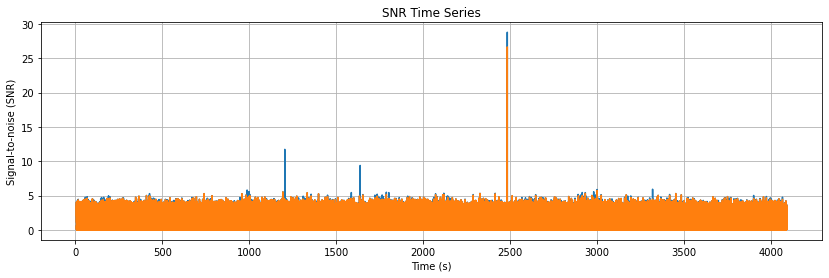

In [10]:
pylab.figure(figsize=[14, 4])
plot_mf(sn.sample_times, sn, label = 'SNR')
plot_mf(sn.sample_times, nsn, label = 'new SNR')

pylab.title('SNR Time Series')
pylab.grid()
pylab.xlabel('Time (s)')
pylab.ylabel('Signal-to-noise (SNR)')
pylab.show()

From the latest plot, we can actually answer to **Challenge 3**: there is a peak around $t\sim 2500 s$ which has a high SNR both in the snr timeseries and the new-snr timeseries.


In [11]:
new_snr = np.array(abs(nsn))
max_idx = np.argmax(new_snr)
merger_time = sn.sample_times[max_idx]
peak_snr = new_snr[max_idx]
print("Found a signal at time {} & SNR {:.3f}, matching component mass {}".format(merger_time, peak_snr, 10))

Found a signal at time 2483.96875 & SNR 26.645, matching component mass 10


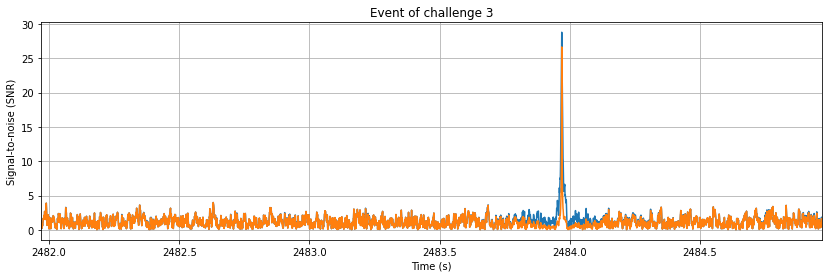

In [12]:
pylab.figure(figsize=[14, 4])
plot_mf(sn.sample_times, sn, label = 'SNR')
plot_mf(sn.sample_times, nsn, label = 'new SNR')

pylab.title('Event of challenge 3')
pylab.grid()
pylab.xlim(merger_time - 2, merger_time + 1)
pylab.xlabel('Time (s)')
pylab.ylabel('Signal-to-noise (SNR)')
pylab.show()

In [13]:
# q transform
t, f, p = cdata['H1'].whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))

In [14]:
crop_idx = (t < merger_time + 10) & (t > merger_time - 10)
# we don't want matplotlib to process all!

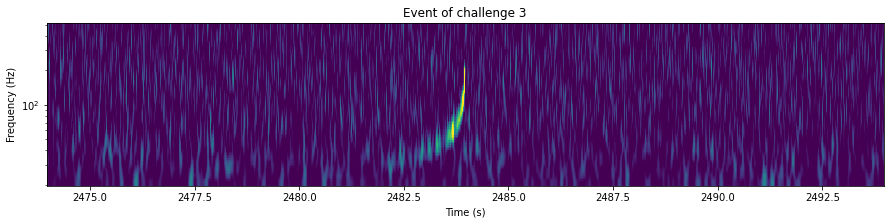

In [15]:
pylab.figure(figsize=[15, 3])
pylab.title('Event of challenge 3')
pylab.pcolormesh(t[crop_idx], f, p[:,crop_idx]**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
#pylab.xlim(merger_time - 2, merger_time + 1)
pylab.show()

<br><br><br>
## **Matched filtering on a large template bank**

We have already the function needed to perform the analysis. We need to account for a larger template bank, though...
- pick a detector
- do the mf with a defined mass template:
    - threshold the first SNR
    - for each threshold save t, peak value and template mass in a dictionary based on the time
        - careful! when creating the template check if in the dictionary already exists a value next to your time value!

### **analysis on detector H1**


running MF on m = 10


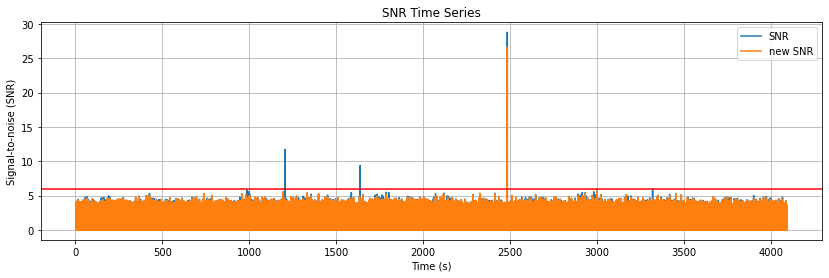

 - matches:   {2483.9688: 26.64}
 - all snr:   {1204.7144: 11.73, 1638.1792: 9.39, 2483.9688: 28.79}
 - all nsnr:  {2483.9688: 26.64}

running MF on m = 11
 - matches:   {}
 - all snr:   {1204.7144: 12.02, 1638.1753: 9.92, 2483.9668: 11.28}
 - all nsnr:  {}

running MF on m = 12
 - matches:   {}
 - all snr:   {987.6831: 6.29, 1204.7129: 13.73, 1638.1602: 12.03, 2483.9624: 9.58, 2920.9844: 6.43}
 - all nsnr:  {}

running MF on m = 13
 - matches:   {}
 - all snr:   {987.6787: 6.31, 1204.7134: 15.94, 1638.1606: 14.11, 2483.9619: 8.32, 3319.2627: 6.5}
 - all nsnr:  {}

running MF on m = 14
 - matches:   {}
 - all snr:   {987.7471: 6.24, 1204.7129: 15.25, 1211.2837: 6.04, 1638.1597: 16.53, 2483.9575: 8.0}
 - all nsnr:  {}

running MF on m = 15
 - matches:   {}
 - all snr:   {987.8892: 6.13, 1204.7124: 18.33, 1638.1592: 18.27, 2483.9609: 7.8}
 - all nsnr:  {}

running MF on m = 16
 - matches:   {1638.1592: 6.79}
 - all snr:   {987.7065: 6.25, 1204.7124: 19.26, 1638.1592: 25.07, 2483.9604: 7.

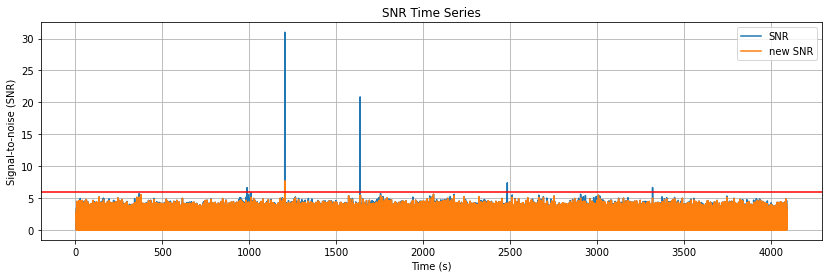

 - matches:   {1204.7114: 7.69}
 - all snr:   {987.7212: 6.63, 1204.7114: 30.98, 1638.1567: 20.85, 2483.9556: 7.39, 3319.2583: 6.65}
 - all nsnr:  {1204.7114: 7.69}

running MF on m = 21
 - matches:   {367.2188: 6.03, 1204.7109: 11.15}
 - all snr:   {367.2188: 6.66, 981.9395: 6.26, 987.7202: 7.15, 1204.7109: 36.68, 1638.1567: 19.59, 2483.9551: 7.81, 3319.2588: 7.7}
 - all nsnr:  {367.2188: 6.03, 1204.7109: 11.15}

running MF on m = 22
 - matches:   {1204.7104: 39.65}
 - all snr:   {987.7197: 7.33, 1204.7104: 44.73, 1638.1558: 19.43, 2483.9541: 7.76, 2995.3462: 6.34, 3319.2573: 8.48}
 - all nsnr:  {1204.7104: 39.65}

running MF on m = 23
 - matches:   {1204.7095: 14.46}
 - all snr:   {987.7104: 7.79, 1204.7095: 39.5, 1638.1558: 18.62, 2483.9536: 7.33, 2995.3457: 6.93, 3319.2568: 8.02}
 - all nsnr:  {1204.7095: 14.46}

running MF on m = 24
 - matches:   {1204.709: 9.84}
 - all snr:   {987.6953: 7.95, 1204.709: 34.84, 1638.1558: 19.03, 2483.9634: 7.46, 2995.3457: 7.5, 3319.2578: 7.66}
 - 

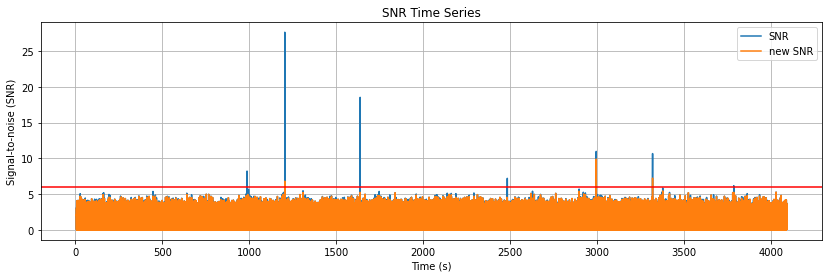

 - matches:   {1204.7075: 6.81, 2995.3438: 9.89, 3319.2559: 7.23}
 - all snr:   {987.6924: 8.22, 1204.7075: 27.62, 1638.1538: 18.52, 2483.9609: 7.21, 2995.3438: 10.97, 3319.2559: 10.67, 3786.1953: 6.17}
 - all nsnr:  {1204.7075: 6.81, 2995.3438: 9.89, 3319.2559: 7.23}

running MF on m = 31
 - matches:   {1204.7075: 6.85, 2995.3428: 10.38, 3319.2559: 8.37}
 - all snr:   {987.6919: 8.67, 1204.7075: 27.43, 1638.1538: 18.38, 2483.9604: 7.39, 2995.3428: 11.39, 3319.2559: 11.28}
 - all nsnr:  {1204.7075: 6.85, 2995.3428: 10.38, 3319.2559: 8.37}

running MF on m = 32
 - matches:   {1204.707: 6.86, 2995.3423: 10.62, 3319.2554: 9.3}
 - all snr:   {987.6919: 8.73, 1204.707: 27.38, 1638.1533: 18.43, 2483.9604: 7.51, 2995.3423: 11.34, 3319.2554: 11.95}
 - all nsnr:  {1204.707: 6.86, 2995.3423: 10.62, 3319.2554: 9.3}

running MF on m = 33
 - matches:   {1204.707: 6.8, 2995.3418: 9.73, 3319.2549: 11.16}
 - all snr:   {987.6914: 8.76, 996.6655: 6.09, 1204.707: 27.02, 1638.1533: 18.73, 2483.96: 7.8, 2

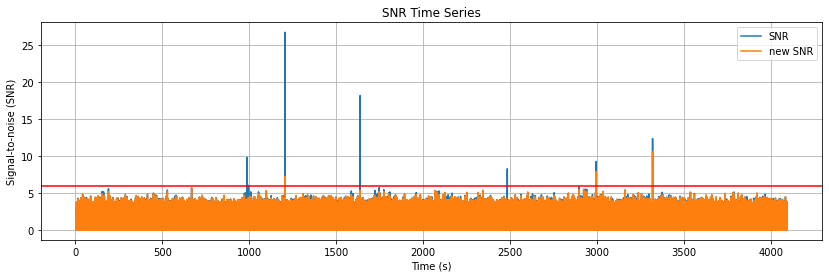

 - matches:   {1204.7051: 7.25, 2995.3394: 7.9, 3319.252: 10.56}
 - all snr:   {987.6758: 9.81, 996.4424: 6.03, 1204.7051: 26.74, 1638.1514: 18.19, 2483.9556: 8.26, 2995.3394: 9.26, 3319.252: 12.36}
 - all nsnr:  {1204.7051: 7.25, 2995.3394: 7.9, 3319.252: 10.56}

running MF on m = 41
 - matches:   {1204.7046: 7.23, 2995.3394: 7.36, 3319.252: 9.7}
 - all snr:   {987.6753: 9.85, 1204.7046: 26.6, 1638.1509: 18.12, 2483.9487: 8.42, 2995.3394: 9.09, 3319.252: 11.99}
 - all nsnr:  {1204.7046: 7.23, 2995.3394: 7.36, 3319.252: 9.7}

running MF on m = 42
 - matches:   {1204.7041: 7.12, 2995.3389: 7.11, 3319.2515: 9.25}
 - all snr:   {987.665: 9.95, 1204.7041: 26.37, 1638.1504: 18.01, 2483.9482: 8.75, 2995.3389: 8.91, 3319.2515: 11.69}
 - all nsnr:  {1204.7041: 7.12, 2995.3389: 7.11, 3319.2515: 9.25}

running MF on m = 43
 - matches:   {1204.7041: 7.11, 2995.3389: 7.24, 3319.2515: 9.02}
 - all snr:   {987.665: 10.34, 1204.7041: 26.23, 1638.1504: 17.89, 2483.9478: 9.07, 2995.3389: 8.71, 3319.251

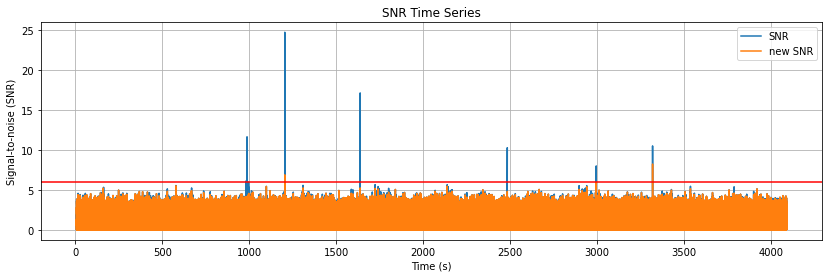

 - matches:   {1204.7017: 6.88, 3319.2495: 8.23}
 - all snr:   {981.9082: 6.12, 987.6626: 11.63, 1204.7021: 24.69, 1638.1475: 17.11, 2483.9438: 10.27, 2995.3369: 7.99, 3319.2495: 10.49}
 - all nsnr:  {1204.7017: 6.88, 3319.2495: 8.23}

overall time candidates: [1204.7144, 1638.1792, 2483.9688, 987.6831, 2920.9844, 3319.2627, 1211.2837, 3373.3652, 367.2188, 981.9395, 2995.3462, 998.9233, 3786.1958, 996.6655, 2896.708]


In [16]:
cdetector = 'H1'

global_cand = []
global_cand_all = []
global_cand_matched = []
all_snr = []
matches = []

make_plots = True
thres = 6

mass_idx = 0
for k, v in mftemplates.items():
    print('\nrunning MF on m =', k)
    
    sn, nsn = unified_matched_filter(cdetector, mftemplates[str(k)])
    tt = sn.sample_times
    
    snr = np.array(abs(sn))
    nsnr = np.array(abs(nsn))
    
    if(make_plots & (mass_idx%10 == 0)):
        pylab.figure(figsize=[14, 4])
        plot_mf(sn.sample_times, snr, label = 'SNR')
        plot_mf(sn.sample_times, nsnr, label = 'new SNR')

        pylab.title('SNR Time Series')
        pylab.grid()
        pylab.xlabel('Time (s)')
        pylab.ylabel('Signal-to-noise (SNR)')
        pylab.legend()
        plt.axhline(y = thres, color = 'r', linestyle = '-')
        
        pylab.show()
    
    cand1 = find_thresholded_window_peaks(snr, tt, 2046, 1023, thres)
    cand2 = find_thresholded_window_peaks(nsnr, tt, 2046, 1023, thres)
    
    matching = dict()
    for key in cand1:
        for kk in cand2:
            if np.isclose( float(key), float(kk), atol=1):
                matching[kk] = cand2[kk]
    
    poll_global_cand(mass_idx, cand1, cand2)
    all_snr.append(cand1)
    matches.append(matching)
    print(' - matches:  ', matching)
    print(' - all snr:  ', cand1)
    print(' - all nsnr: ', cand2)
    
    mass_idx += 1

print('\noverall time candidates:', global_cand)

In [17]:
sort_idx = np.argsort(global_cand)
sort_idx

array([ 8,  9,  3, 13, 11,  0,  6,  1,  2, 14,  4, 10,  5,  7, 12])

In [18]:
all_times = np.array(global_cand)[sort_idx]
all_alerts = np.matrix(global_cand_all)[sort_idx]
all_match = np.matrix(global_cand_matched)[sort_idx]

In [19]:
all_alerts  #rows are each time candidate, columns are m values

matrix([[  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,  6.66,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,  6.26,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,  6.04,  6.08,  6.12],
        [  nan,   nan,  6.29,  6.31,  6.24,  6.13,  6.25,  6.56,  6.87,
          7.16,  6.63,  7.15,  7.33,  7.79,  7.95,  8.24,  8.17,  8.07,
          8.07,  8.15,  8.22,  8.67,  8.73,  8.76,  8.85,  8.9 ,  8.87,
          9.11,  9.41,  9.66,  9.81,  9.85,  9.95, 10.34, 10.66, 10.91,
         11.1 , 11.26, 11.4 , 11.51, 11.63],
 

In [20]:
all_match  #rows are each time candidate, columns are m values

matrix([[  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,  6.03,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
           nan,   nan,   nan,   nan,   nan],
 

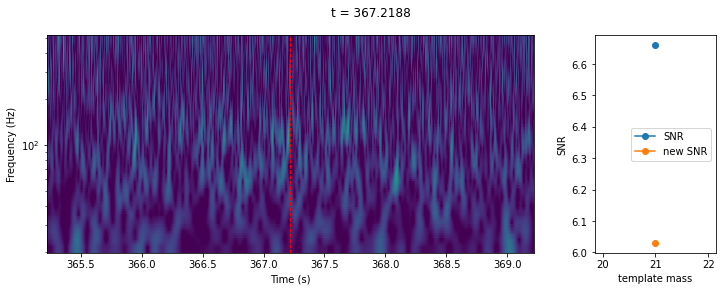

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 6.66  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 6.03  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
*** max nsrn 6.03 for m=21


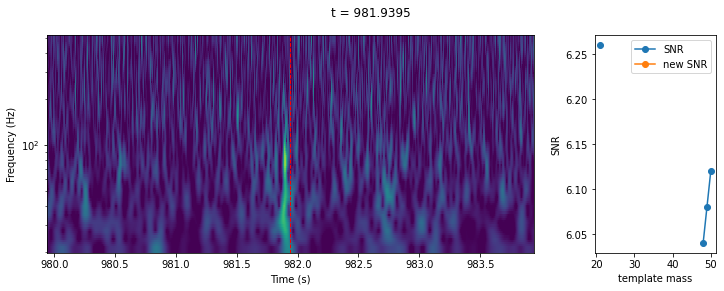

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 6.26  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 6.04 6.08 6.12]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


/tmp/ipykernel_175970/1800176363.py:27: RuntimeWarning: All-NaN axis encountered
  valueSNR = np.nanmax(all_match[i])


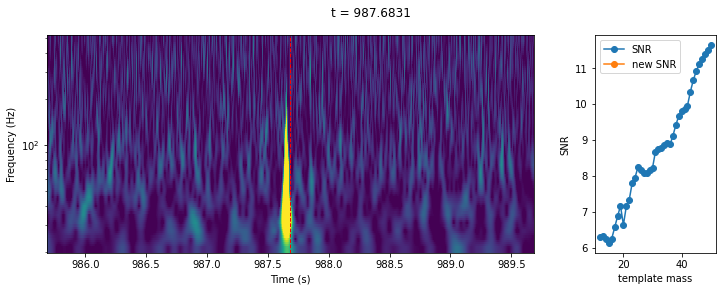

snr	 [[  nan   nan  6.29  6.31  6.24  6.13  6.25  6.56  6.87  7.16  6.63  7.15
   7.33  7.79  7.95  8.24  8.17  8.07  8.07  8.15  8.22  8.67  8.73  8.76
   8.85  8.9   8.87  9.11  9.41  9.66  9.81  9.85  9.95 10.34 10.66 10.91
  11.1  11.26 11.4  11.51 11.63]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


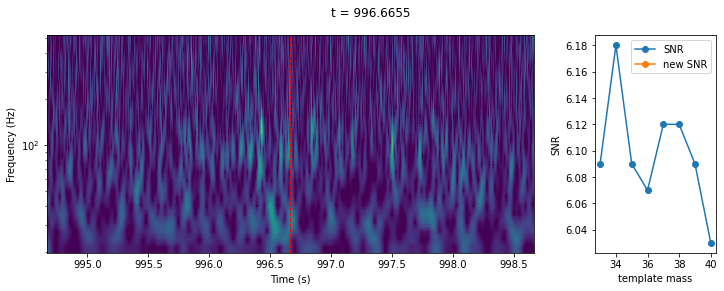

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan 6.09 6.18 6.09 6.07 6.12
  6.12 6.09 6.03  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


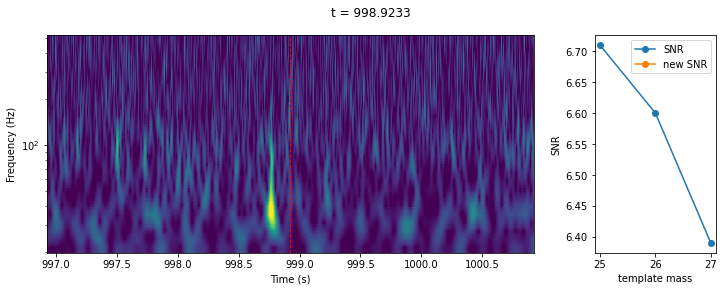

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan 6.71 6.6  6.39  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


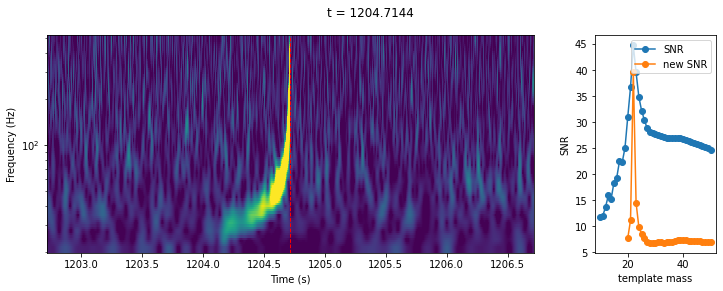

snr	 [[11.73 12.02 13.73 15.94 15.25 18.33 19.26 22.44 22.27 25.06 30.98 36.68
  44.73 39.5  34.84 32.14 30.41 28.74 28.05 27.78 27.62 27.43 27.38 27.02
  26.99 26.85 26.84 26.83 26.93 26.85 26.74 26.6  26.37 26.23 26.01 25.78
  25.58 25.33 25.13 24.92 24.69]]
nsnr	 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan  7.69 11.15
  39.65 14.46  9.84  8.44  7.69  7.01  6.81  6.76  6.81  6.85  6.86  6.8
   6.96  6.93  6.96  7.05  7.23  7.26  7.25  7.23  7.12  7.11  7.13  7.06
   7.05  7.02  6.98  6.97  6.88]]
*** max nsrn 39.65 for m=22


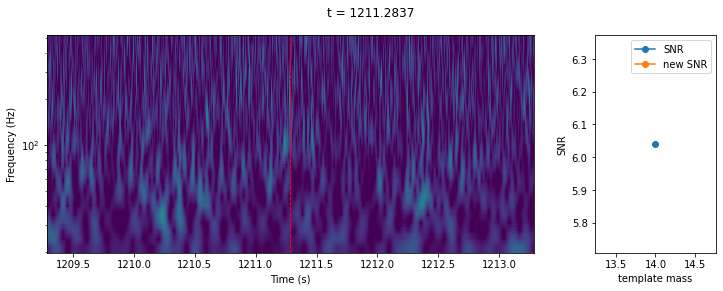

snr	 [[ nan  nan  nan  nan 6.04  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


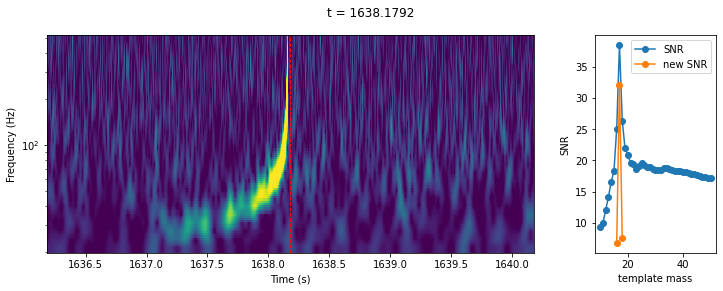

snr	 [[ 9.39  9.92 12.03 14.11 16.53 18.27 25.07 38.41 26.36 21.95 20.85 19.59
  19.43 18.62 19.03 19.57 19.27 18.88 18.9  18.67 18.52 18.38 18.43 18.73
  18.84 18.65 18.45 18.33 18.33 18.28 18.19 18.12 18.01 17.89 17.8  17.68
  17.54 17.41 17.31 17.21 17.11]]
nsnr	 [[  nan   nan   nan   nan   nan   nan  6.79 32.04  7.55   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan]]
*** max nsrn 32.04 for m=17


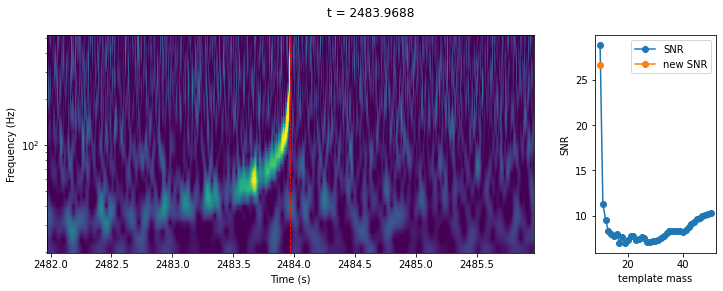

snr	 [[28.79 11.28  9.58  8.32  8.    7.8   7.99  7.06  7.69  7.02  7.39  7.81
   7.76  7.33  7.46  7.64  7.51  7.08  7.1   7.22  7.21  7.39  7.51  7.8
   8.1   8.29  8.32  8.32  8.31  8.29  8.26  8.42  8.75  9.07  9.36  9.61
   9.81  9.98 10.11 10.2  10.27]]
nsnr	 [[26.64   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan]]
*** max nsrn 26.64 for m=10


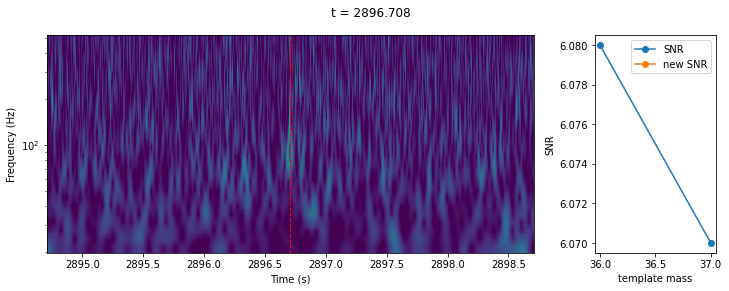

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 6.08 6.07
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


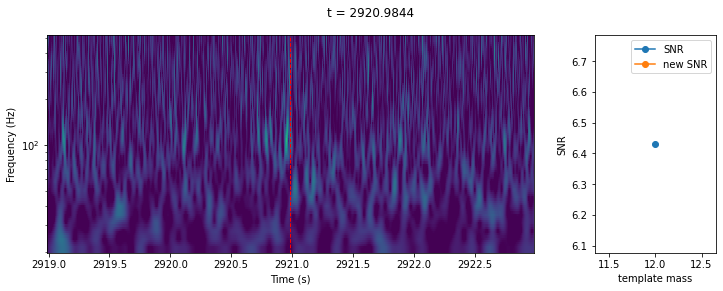

snr	 [[ nan  nan 6.43  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


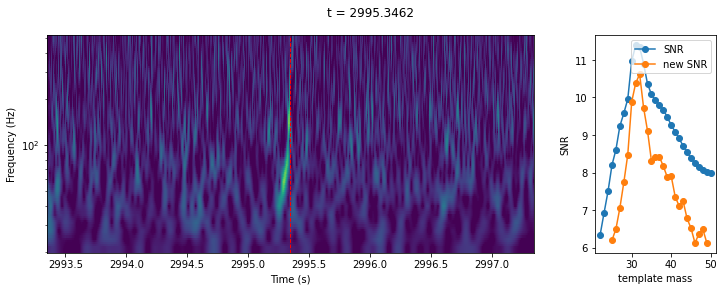

snr	 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   6.34  6.93  7.5   8.2   8.61  9.24  9.58  9.96 10.97 11.39 11.34 10.9
  10.36 10.08  9.92  9.8   9.67  9.48  9.26  9.09  8.91  8.71  8.56  8.38
   8.26  8.15  8.08  8.03  7.99]]
nsnr	 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan  6.2   6.5   7.06  7.74  8.48  9.89 10.38 10.62  9.73
   9.11  8.3   8.42  8.42  8.17  7.88  7.9   7.36  7.11  7.24  6.78  6.52
   6.13  6.37  6.49  6.13   nan]]
*** max nsrn 10.62 for m=32


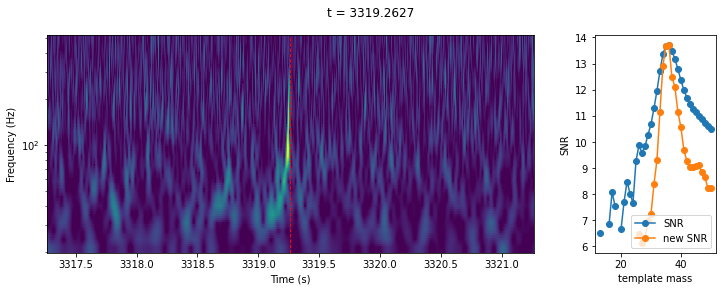

snr	 [[  nan   nan   nan  6.5    nan   nan  6.85  8.07  7.55   nan  6.65  7.7
   8.48  8.02  7.66  9.28  9.87  9.58  9.83 10.27 10.67 11.28 11.95 12.71
  13.36 13.69 13.7  13.48 13.17 12.79 12.36 11.99 11.69 11.45 11.27 11.13
  11.   10.86 10.74 10.6  10.49]]
nsnr	 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan  6.48  6.13  6.3   6.97  7.23  8.37  9.3  11.16
  12.91 13.69 13.7  12.49 12.11 11.15 10.56  9.7   9.25  9.02  9.03  9.09
   9.12  8.83  8.65  8.25  8.23]]
*** max nsrn 13.7 for m=36


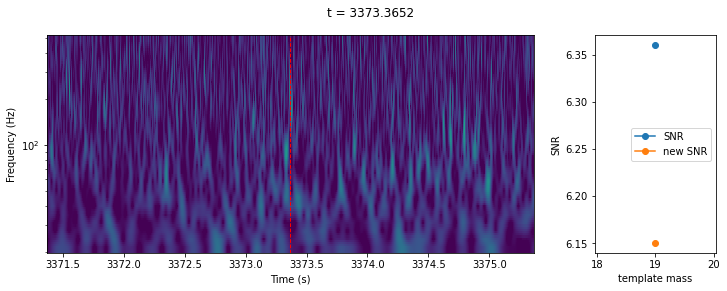

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan 6.36  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan 6.15  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
*** max nsrn 6.15 for m=19


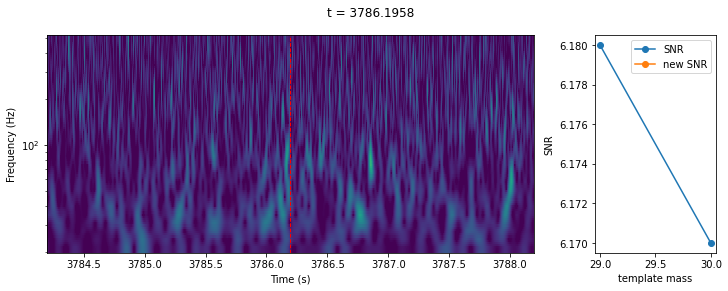

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan 6.18 6.17  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


In [21]:
for i, this_t in enumerate(all_times):
    #print(this_t, '++++++++++++++++++++++++')
    
    crop_idx = (t < this_t + 2) & (t > this_t - 2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(f't = {this_t}')

    #pylab.figure(figsize=[15, 3])
    #pylab.title(f't = {this_t}')
    im = ax1.pcolormesh(t[crop_idx], f, p[:,crop_idx]**0.5, vmin=0.5, vmax=7, shading='auto')
    #fig.colorbar(im, ax=ax1)
    ax1.axvline(x = this_t, color = 'r', linestyle = '--', lw=1)
    ax1.set_yscale('log')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    
    ax2.plot(masses, all_alerts[i].T, marker='o', label='SNR')
    ax2.plot(masses, all_match[i].T, marker='o', label='new SNR')
    ax2.set_xlabel('template mass')
    ax2.set_ylabel('SNR')
    ax2.legend()
    plt.show()
    
    print('snr\t', all_alerts[i])
    print('nsnr\t', all_match[i])
    valueSNR = np.nanmax(all_match[i])
    try:
        valueSNR_mass = masses[np.nanargmax(all_match[i])]
    except:
        valueSNR_mass = '-'
    print(f'*** max nsrn {valueSNR} for m={valueSNR_mass}')

#### **results on H1**

| time | classification | SNR | template mass |
| :-: | :-: | :-: | :-: |
| 981.9 | glitch | - | - |
| 987.6 | glitch | - | - |
| 998.8 | glitch | - | - |
|1204.71| gw | 39.65 | 22 |
|1638.17| gw | 32.04 | 17 |
|2483.96| gw | 26.64 | 10 |
|2995.34| gw | 10.62 | 32 |
|3319.26| gw | 13.7 | 36 |

***

### **analysis on detector L1**

In [22]:
cdetector = 'L1'

In [23]:
# q transform
t, f, p = cdata[cdetector].whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))

In [24]:
global_cand = []
global_cand_all = []
global_cand_matched = []
all_snr = []
matches = []

make_plots = False
thres = 6

mass_idx = 0
for k, v in mftemplates.items():
    print('\nrunning MF on m =', k)
    
    sn, nsn = unified_matched_filter(cdetector, mftemplates[str(k)])
    tt = sn.sample_times
    
    snr = np.array(abs(sn))
    nsnr = np.array(abs(nsn))
    
    if make_plots:
        pylab.figure(figsize=[14, 4])
        plot_mf(sn.sample_times, snr, label = 'SNR')
        plot_mf(sn.sample_times, nsnr, label = 'new SNR')

        pylab.title('SNR Time Series')
        pylab.grid()
        pylab.xlabel('Time (s)')
        pylab.ylabel('Signal-to-noise (SNR)')
        pylab.legend()
        plt.axhline(y = thres, color = 'r', linestyle = '-')
        
        pylab.show()
    
    cand1 = find_thresholded_window_peaks(snr, tt, 2046, 1023, thres)
    cand2 = find_thresholded_window_peaks(nsnr, tt, 2046, 1023, thres)
    
    matching = dict()
    for key in cand1:
        for kk in cand2:
            if np.isclose( float(key), float(kk), atol=1):
                matching[kk] = cand2[kk]
    
    poll_global_cand(mass_idx, cand1, cand2)
    all_snr.append(cand1)
    matches.append(matching)
    print(' - matches:  ', matching)
    print(' - all snr:  ', cand1)
    print(' - all nsnr: ', cand2)
    
    mass_idx += 1

print('\noverall time candidates:', global_cand)


running MF on m = 10
 - matches:   {2483.9688: 29.61}
 - all snr:   {196.1934: 7.64, 1204.7485: 10.13, 1638.1807: 8.29, 2483.9688: 33.51}
 - all nsnr:  {2483.9688: 29.61}

running MF on m = 11
 - matches:   {}
 - all snr:   {196.1572: 7.84, 1204.7568: 10.42, 1638.2139: 9.48, 2483.9541: 10.88}
 - all nsnr:  {}

running MF on m = 12
 - matches:   {}
 - all snr:   {196.0962: 7.35, 1204.7188: 12.41, 1638.1978: 10.63, 2483.9443: 8.48}
 - all nsnr:  {}

running MF on m = 13
 - matches:   {}
 - all snr:   {196.1172: 8.16, 197.3384: 6.14, 1204.7134: 13.07, 1638.1714: 12.65, 2483.9326: 7.66}
 - all nsnr:  {}

running MF on m = 14
 - matches:   {}
 - all snr:   {82.5327: 6.24, 196.1362: 8.04, 1204.7134: 14.71, 1638.168: 15.6, 2483.9229: 7.77}
 - all nsnr:  {}

running MF on m = 15
 - matches:   {}
 - all snr:   {196.0869: 8.16, 1204.7124: 15.86, 1638.1592: 17.57, 2483.9097: 7.6, 3319.2598: 6.06}
 - all nsnr:  {}

running MF on m = 16
 - matches:   {}
 - all snr:   {196.0977: 8.6, 1204.7129: 17.

In [25]:
sort_idx = np.argsort(global_cand)
all_times = np.array(global_cand)[sort_idx]
all_alerts = np.matrix(global_cand_all)[sort_idx]
all_match = np.matrix(global_cand_matched)[sort_idx]

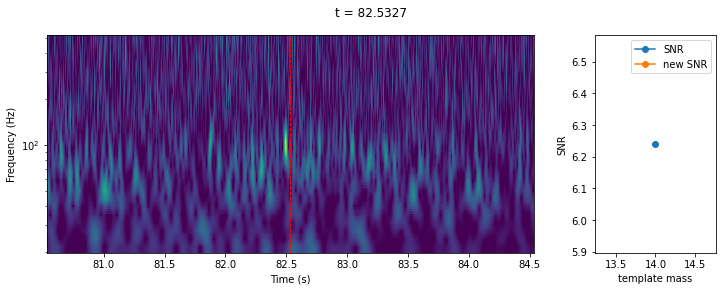

snr	 [[ nan  nan  nan  nan 6.24  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


/tmp/ipykernel_175970/3835401762.py:25: RuntimeWarning: All-NaN axis encountered
  valueSNR = np.nanmax(all_match[i])


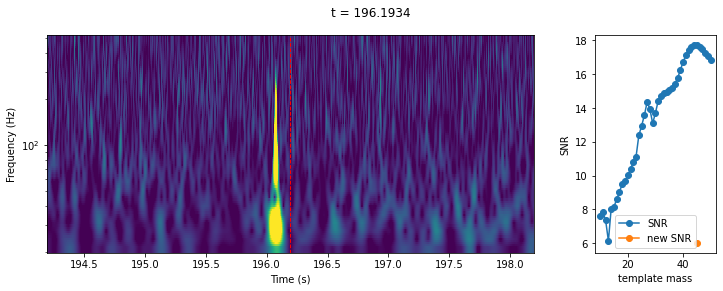

snr	 [[ 7.64  7.84  7.35  6.14  8.04  8.16  8.6   9.05  9.5   9.66 10.01 10.39
  10.81 11.13 12.38 12.94 13.57 14.35 13.93 13.09 13.71 14.42 14.71 14.9
  14.97 15.04 15.2  15.42 15.76 16.24 16.73 17.11 17.43 17.61 17.7  17.71
  17.6  17.48 17.26 17.05 16.82]]
nsnr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan 6.02  nan  nan  nan  nan  nan]]
*** max nsrn 6.02 for m=45


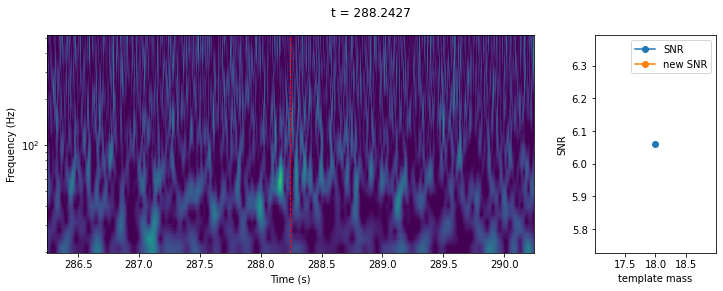

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan 6.06  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


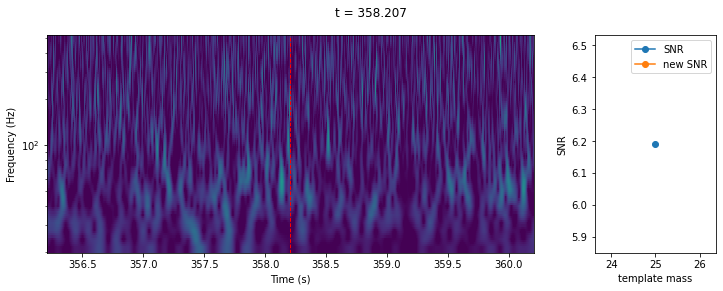

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan 6.19  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
nsnr	 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
*** max nsrn nan for m=-


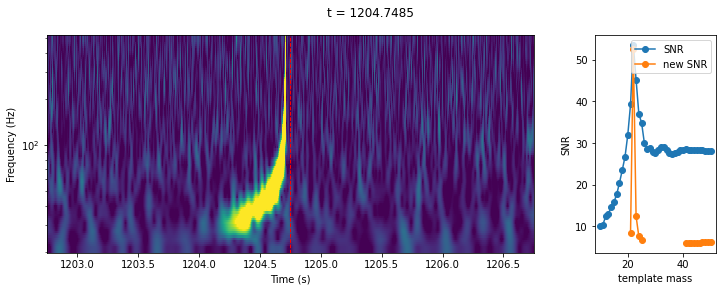

snr	 [[10.13 10.42 12.41 13.07 14.71 15.86 17.74 20.47 23.5  26.72 31.95 39.27
  53.48 45.23 37.04 34.85 30.   28.68 28.73 27.9  27.53 28.23 29.02 28.97
  28.27 27.67 27.43 27.6  27.98 28.24 28.36 28.47 28.46 28.35 28.36 28.31
  28.23 28.24 28.22 28.17 28.12]]
nsnr	 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan  8.49
  52.58 12.46  7.61  6.86   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan  6.06  6.12  6.07  6.11  6.14
   6.15  6.21  6.27  6.32  6.36]]
*** max nsrn 52.58 for m=22


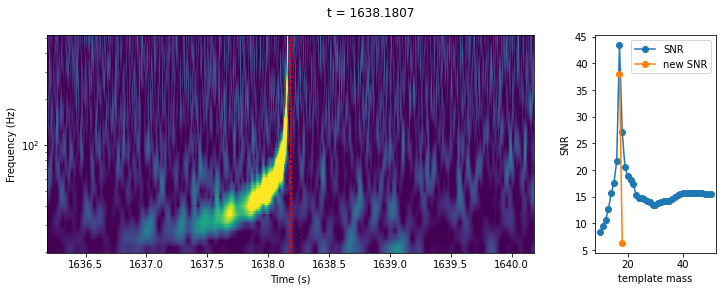

snr	 [[ 8.29  9.48 10.63 12.65 15.6  17.57 21.6  43.41 27.06 20.5  18.8  18.21
  17.38 15.34 14.82 14.72 14.51 14.14 13.97 13.51 13.4  13.75 14.08 14.15
  14.09 14.25 14.59 14.96 15.28 15.51 15.65 15.71 15.72 15.71 15.69 15.65
  15.62 15.59 15.57 15.55 15.55]]
nsnr	 [[  nan   nan   nan   nan   nan   nan   nan 38.06  6.31   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan]]
*** max nsrn 38.06 for m=17


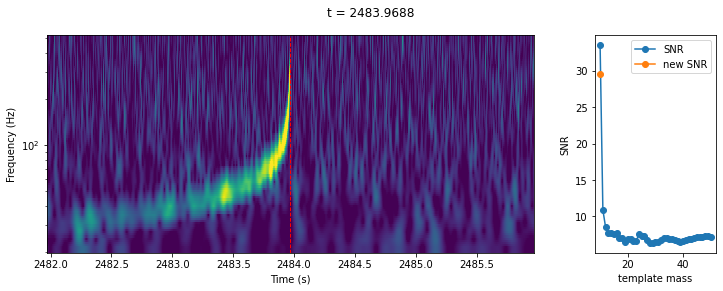

snr	 [[33.51 10.88  8.48  7.66  7.77  7.6   7.76  7.07  7.09  6.55  6.83  6.95
   6.66  6.57  7.53  7.35  7.36  6.76  6.36  6.4   6.51  6.54  6.78  7.
   7.05  6.96  6.84  6.74  6.64  6.52  6.56  6.71  6.83  6.94  7.04  7.12
   7.18  7.23  7.26  7.26  7.23]]
nsnr	 [[29.61   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan]]
*** max nsrn 29.61 for m=10


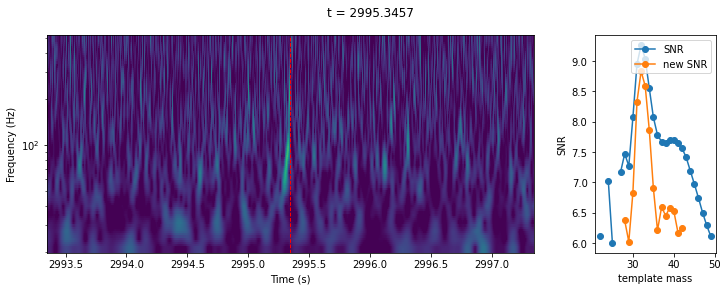

snr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 6.12  nan
  7.02 6.    nan 7.17 7.47 7.27 8.07 8.95 9.26 9.04 8.55 8.07 7.78 7.67
  7.64 7.7  7.69 7.64 7.56 7.41 7.19 6.97 6.74 6.5  6.29 6.11  nan]]
nsnr	 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan 6.37 6.02 6.83 8.33 8.83 8.59 7.86 6.9  6.21 6.59
  6.45 6.58 6.52 6.17 6.25  nan  nan  nan  nan  nan  nan  nan  nan]]
*** max nsrn 8.83 for m=32


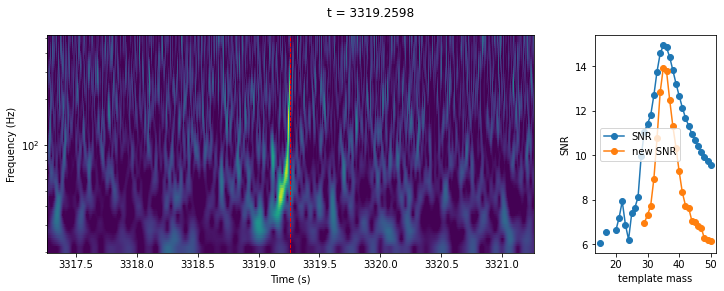

snr	 [[  nan   nan   nan   nan   nan  6.06   nan  6.54   nan   nan  6.63  7.19
   7.93  6.88  6.21  7.39  7.64  8.12  9.98 11.04 11.41 11.8  12.69 13.76
  14.57 14.94 14.84 14.41 13.82 13.22 12.67 12.14 11.68 11.32 10.96 10.7
  10.4  10.16  9.91  9.72  9.55]]
nsnr	 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
    nan   nan   nan   nan   nan   nan   nan  6.97  7.32  7.74  8.93 10.76
  12.84 13.94 13.78 12.49 11.31 10.34  9.27  8.33  7.74  7.64  7.06  6.99
   6.83  6.72  6.26  6.21  6.13]]
*** max nsrn 13.94 for m=35


In [26]:
for i, this_t in enumerate(all_times):
    #print(this_t, '++++++++++++++++++++++++')
    
    crop_idx = (t < this_t + 2) & (t > this_t - 2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(f't = {this_t}')

    im = ax1.pcolormesh(t[crop_idx], f, p[:,crop_idx]**0.5, vmin=0.5, vmax=7, shading='auto')
    ax1.axvline(x = this_t, color = 'r', linestyle = '--', lw=1)
    #fig.colorbar(im, ax=ax1)
    ax1.set_yscale('log')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    
    ax2.plot(masses, all_alerts[i].T, marker='o', label='SNR')
    ax2.plot(masses, all_match[i].T, marker='o', label='new SNR')
    ax2.set_xlabel('template mass')
    ax2.set_ylabel('SNR')
    ax2.legend()
    plt.show()
    
    print('snr\t', all_alerts[i])
    print('nsnr\t', all_match[i])
    valueSNR = np.nanmax(all_match[i])
    try:
        valueSNR_mass = masses[np.nanargmax(all_match[i])]
    except:
        valueSNR_mass = '-'
    print(f'*** max nsrn {valueSNR} for m={valueSNR_mass}')

#### **results on L1**

| time | classification | SNR | template mass |
| :-: | :-: | :-: | :-: |
|196.1 | glitch | - | - |
|1204.74 | gw | 52.58 | 22 |
|1638.18 | gw | 38.06 | 17 |
|2483.96 | gw | 29.61 | 10 |
|2995.34 | gw | 8.83 | 32 |
|3319.25 | gw | 13.94 | 35 |

***

<br><br>
## summary of **signal & glitches**

Both detector agree on these **gravitational waves**:

| H1 time | H1 SNR | H1 mass | L1 time | L1 SNR | L1 mass |
| :-: | :-: | :-: | :-: | :-: | :-: |
|1204.71| 39.65 | 22 | 1204.74 | 52.58 | 22 |
|1638.17| 32.04 | 17 | 1638.18 | 38.06 | 17 |
|2483.96| 26.64 | 10 | 2483.96 | 29.61 | 10 |
|2995.34| 10.62 | 32 | 2995.34 |  8.83 | 32 |
|3319.26| 13.7  | 36 | 3319.25 | 13.94 | 35 |

I list the following **glitches**:

| detector | time |
| :-: | :-: |
| L1 |196.1 |
| H1 | 981.9 |
| H1 | 987.6 |
| H1 | 998.8 |

The plot of those glitches can be found above.